# Will it rain in Rome over the next 3 weekends?

This notebook demonstrates how to use **Destination Earth Climate Digital Twin (DT) data** 
to answer a simple but practical question:  

> *Will it rain in Rome over the next 3 weekends?*

We’ll:
1. Select a dataset with precipitation forecasts.  
2. Extract values for Rome’s location.  
3. Aggregate rainfall totals over each weekend.  
4. Report a simple "Rain" or "No Rain" answer.

In [1]:
pip install pygrib

Note: you may need to restart the kernel to use updated packages.


## setup

In [2]:
import destinelab as deauth
import json
import datetime
import importlib
import importlib.metadata as metadata

import requests
from requests.adapters import HTTPAdapter
import os
from getpass import getpass
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON

import sys
import subprocess
from packaging import version

from IPython.display import display, HTML
import healpy as hp

In [3]:

from datetime import datetime, timedelta
import pandas as pd
import geopandas
import xarray as xr
import pygrib

import matplotlib.pyplot as plt
import dask

In [4]:


#convert grib to csv and clip to bounding
def filter_grib_to_xr(input_grib_file, lat_min, lat_max, lon_min, lon_max):
    dataset = xr.open_dataset(input_grib_file, engine='cfgrib')

    filtered_dataset = dataset.where(
        (dataset.latitude >= lat_min) &
        (dataset.latitude <= lat_max) &
        (dataset.longitude >= lon_min) &
        (dataset.longitude <= lon_max),
        drop=True
    )

    return filtered_dataset 


## Download

### Authentication

In [5]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  serena.avolio
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### check DT access

In [6]:
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


### Order

In [7]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"

In [8]:
ecmwf_properties={
'ecmwf:resolution': 'high',
 'ecmwf:model': 'IFS-NEMO',
 'ecmwf:type': 'fc',
 'ecmwf:dataset': 'climate-dt',
 'ecmwf:param': '228',
 'ecmwf:levtype': 'sfc',
 'ecmwf:expver': '0001',
 'ecmwf:date': '20250924/to/20251015',
 'ecmwf:realization': '1',
 'ecmwf:activity': 'ScenarioMIP',
 'ecmwf:class': 'd1',
 'ecmwf:stream': 'clte',
 'ecmwf:time': '0000',
 'ecmwf:experiment': 'SSP3-7.0',
 'ecmwf:generation': '1'}


In [9]:
response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=ecmwf_properties, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")    

Product ordered: 29a5c7d8-7f72-4eea-8133-50701fc8b6e6
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: shipping


In [10]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")

Polling 1/300
Polling 2/300
Polling 3/300
Product is ready to be downloaded.
Asset URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/29a5c7d8-7f72-4eea-8133-50701fc8b6e6/downloadLink


In [11]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(self_url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 29a5c7d8-7f72-4eea-8133-50701fc8b6e6.grib


291MB [00:08, 34.3MB/s] 


In [12]:
download_path =  filename

In [13]:
rome_lon= 12.5
rome_lat= 41.9

In [14]:
rome_ds= filter_grib_to_xr(filename , rome_lat-0.05, rome_lat+0.05, rome_lon-0.05, rome_lon+0.05)
rome_ds

/opt/conda/envs/python_dedl/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 680B
Dimensions:     (time: 22, values: 3)
Coordinates:
  * time        (time) datetime64[ns] 176B 2025-09-24 2025-09-25 ... 2025-10-15
    step        timedelta64[ns] 8B 01:00:00
    surface     float64 8B 0.0
    latitude    (values) float64 24B 41.86 41.91 41.91
    longitude   (values) float64 24B 12.54 12.46 12.55
    valid_time  (time) datetime64[ns] 176B ...
Dimensions without coordinates: values
Data variables:
    tp          (time, values) float32 264B 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          1003
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-24T08:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
weekends = pd.date_range("2025-09-27", periods=3, freq="7D")

weekends

DatetimeIndex(['2025-09-27', '2025-10-04', '2025-10-11'], dtype='datetime64[ns]', freq='7D')

In [17]:
results = {}

for start in weekends:
    # Weekend = Sat (start) + Sun (start+1)
    end = start + pd.Timedelta(days=1)
    
    weekend_data = rome_ds.sel(time=slice(start, end))
    total_precip = weekend_data['tp'].sum().item()  # assuming variable is called 'precip'
    
    results[str(start.date())] = "🌧️ Rain" if total_precip > 1.0 else "☀️ No Rain"

display(results)

{'2025-09-27': '☀️ No Rain',
 '2025-10-04': '☀️ No Rain',
 '2025-10-11': '☀️ No Rain'}

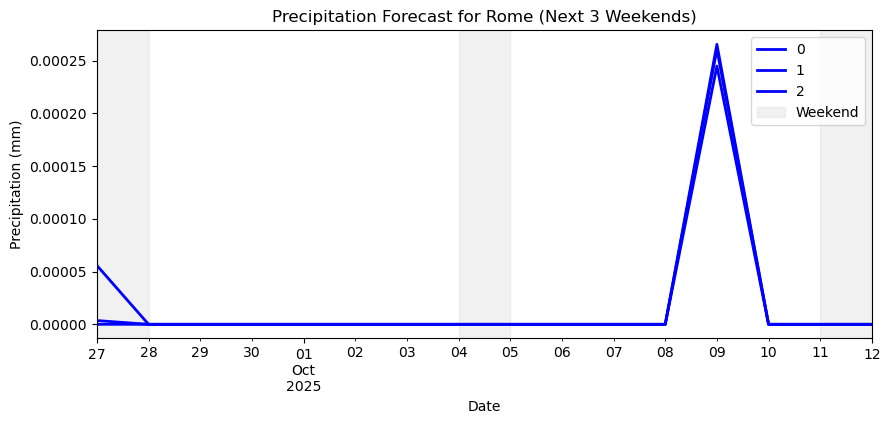

In [19]:
import matplotlib.pyplot as plt

# Extract precipitation time series for Rome
rome_precip = rome_ds['tp'].to_pandas()

# Plot only the period covering the 3 weekends
plot_start = weekends[0]
plot_end = weekends[-1] + pd.Timedelta(days=1)
rome_precip = rome_precip.loc[plot_start:plot_end]

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
rome_precip.plot(ax=ax, lw=2, color="blue")

# Highlight weekends
for start in weekends:
    end = start + pd.Timedelta(days=1)
    ax.axvspan(start, end, color="lightgray", alpha=0.3, label="Weekend" if start == weekends[0] else "")

ax.set_title("Precipitation Forecast for Rome (Next 3 Weekends)")
ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Date")
ax.legend()
plt.show()